In [13]:
import pandas as pd

pd.set_option("display.max_columns", None)  # Toont alle kolommen
pd.set_option("display.width", 100)  # Voorkomt afkapping van kolommen
pd.set_option("display.max_rows", 1400)  # Beperkt aantal rijen om overzichtelijk te blijven

In [14]:
df_Full_dataset = pd.read_csv('TEG_Data&Weather_2Years_WithNAN.csv')

In [ ]:
import pandas as pd

df = df_Full_dataset

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Month'] = df['Timestamp'].dt.month

In [ ]:
import numpy as np
import pandas as pd

df = df_Full_dataset.copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.set_index("Timestamp").sort_index()

df["Energy_lag_1"] = df["Energy (J)"].shift(1)
df["Energy_lag_2"] = df["Energy (J)"].shift(2)
df["Moving_average_energy_3"] = df["Energy (J)"].shift(1).rolling(window=3).mean()

df["Direct_radiation_lag_1"] = df["direct_rad:W"].shift(1)
df["Direct_radiation_lag_2"] = df["direct_rad:W"].shift(2)
df["Moving_average_direct_radiation_3"] = df["direct_rad:W"].shift(1).rolling(window=3).mean()

df["Ambient_Temperature_lag_1"] = df["Ambient_Temperature"].shift(1)
df["Ambient_Temperature_lag_2"] = df["Ambient_Temperature"].shift(2)
df["Moving_average_Ambient_Temperature_3"] = df["Ambient_Temperature"].shift(1).rolling(window=3).mean()

df["Ground_50cm_Temperature_lag_1"] = df["Ground_50cm_Temperature"].shift(1)
df["Ground_50cm_Temperature_lag_2"] = df["Ground_50cm_Temperature"].shift(2)
df["Moving_average_Ground_50cm_Temperature_3"] = df["Ground_50cm_Temperature"].shift(1).rolling(window=3).mean()

df["Hour_direct_interaction"] = df["Hour"] * df["direct_rad:W"]

# Targets
df["Energy_sum_target_30minutes"] = df["Energy (J)"].shift(-5).rolling(window=6, min_periods=6).sum()
df["Energy_sum_target_1hour"] = df["Energy (J)"].shift(-11).rolling(window=12, min_periods=12).sum()
df["Energy_sum_target_6hours"] = df["Energy (J)"].shift(-66).rolling(window=72, min_periods=72).sum()
df["Energy_sum_target_12hours"] = df["Energy (J)"].shift(-132).rolling(window=144, min_periods=144).sum()
df["Energy_sum_target_24hours"] = df["Energy (J)"].shift(-264).rolling(window=288, min_periods=288).sum()

YEAR1 = df.loc["2022-10-01":"2023-09-30"].dropna()
YEAR2 = df.loc["2023-10-01":"2024-08-31"].dropna()



In [ ]:
import numpy as np, pandas as pd, math, warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")


# 1. Data – tijdindex zeker stellen
if not isinstance(df.index, pd.DatetimeIndex):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.set_index("Timestamp").sort_index()

# 2. Features & target
features = [
    "direct_rad:W","Direct_radiation_lag_1","Direct_radiation_lag_2",
    "Moving_average_direct_radiation_3",
    "Ground_50cm_Temperature","Ground_50cm_Temperature_lag_1",
    "Ground_50cm_Temperature_lag_2","Moving_average_Ground_50cm_Temperature_3",
    "Ambient_Temperature",
    "Energy_lag_1","Energy_lag_2","Moving_average_energy_3",
    "Hour","Month",

    "precip_5min:mm",
    "dew_point_2m:C",
    "relative_humidity_2m:p",
    "visibility:m",
    "wind_dir_10m:d",
    "wind_speed_10m:ms",
    "sfc_pressure:Pa"
]

target = "Energy_sum_target_1hour"

# 3. Jaarblokken & 80-/20-split
split_ix = int(len(YEAR1) * 0.8)
train_df = YEAR1.iloc[:split_ix]
val_df   = YEAR1.iloc[split_ix:]

X_train, y_train = train_df[features], train_df[target]
X_val  , y_val   = val_df[features] , val_df[target]


# 4. Baseline Mean Model
train_mean = y_train.mean()

# Train: predict eigen gemiddelde (toegestaan)
train_pred = np.full_like(y_train, fill_value=train_mean, dtype=np.float64)

# Val/Test: je mag de y daar niet kennen, dus gebruik train_mean
val_pred = np.full_like(y_val, fill_value=train_mean, dtype=np.float64)


# 5. Train- & validatie-scores (baseline)
def metr(y_true, y_pred):
    """Geef MAE, RMSE en R² terug."""
    return (
        mean_absolute_error(y_true, y_pred),
        math.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    )

mae_tr, rmse_tr, r2_tr   = metr(y_train, train_pred)
mae_val, rmse_val, r2_val = metr(y_val,   val_pred)

print("\nBaseline (mean uit TRAIN) resultaten")
print(f"  TRAIN  MAE {mae_tr:.3f} | RMSE {rmse_tr:.3f} | R² {r2_tr:.3f}")
print(f"  VAL    MAE {mae_val:.3f} | RMSE {rmse_val:.3f} | R² {r2_val:.3f}")


# 6. Seizoens-evaluatie in jaar 2 
season_blocks = [
    ("Herfst 23",   "2023-10-01", "2023-11-30"),
    ("Winter 23/24", "2023-12-01", "2024-02-29"),
    ("Lente 24",     "2024-03-01", "2024-05-31"),
    ("Zomer 24",     "2024-06-01", "2024-08-31"),
]

mae_l, rmse_l, r2_l = [], [], []
print("\nSeizoens-scores (baseline mean uit TRAIN, jaar 2)")

for name, d1, d2 in season_blocks:
    block = YEAR2.loc[d1:d2]
    if block.empty:
        print(f"{name:10s} – geen rijen in deze periode")
        continue

    y_true = block[target]
    y_pred = np.full_like(y_true, fill_value=train_mean, dtype=np.float64)

    mae, rmse, r2 = metr(y_true, y_pred)
    mae_l.append(mae); rmse_l.append(rmse); r2_l.append(r2)

    print(f"{name:10s}  MAE {mae:.3f} | RMSE {rmse:.3f} | R² {r2:.3f}")

if mae_l:
    print("\nGemiddeld over vier seizoenen")
    print(f"  MAE  {np.mean(mae_l):.3f}")
    print(f"  RMSE {np.mean(rmse_l):.3f}")
    print(f"  R²   {np.mean(r2_l):.3f}")





Baseline (mean uit TRAIN) resultaten
  TRAIN  MAE 0.913 | RMSE 2.076 | R² 0.000
  VAL    MAE 1.404 | RMSE 3.110 | R² -0.024

Seizoens-scores (baseline mean uit TRAIN, jaar 2)
Herfst 23   MAE 0.602 | RMSE 0.831 | R² -0.032
Winter 23/24  MAE 0.620 | RMSE 0.706 | R² -1.239
Lente 24    MAE 1.316 | RMSE 3.056 | R² -0.027
Zomer 24    MAE 1.545 | RMSE 3.473 | R² -0.037

Gemiddeld over vier seizoenen
  MAE  1.021
  RMSE 2.016
  R²   -0.334


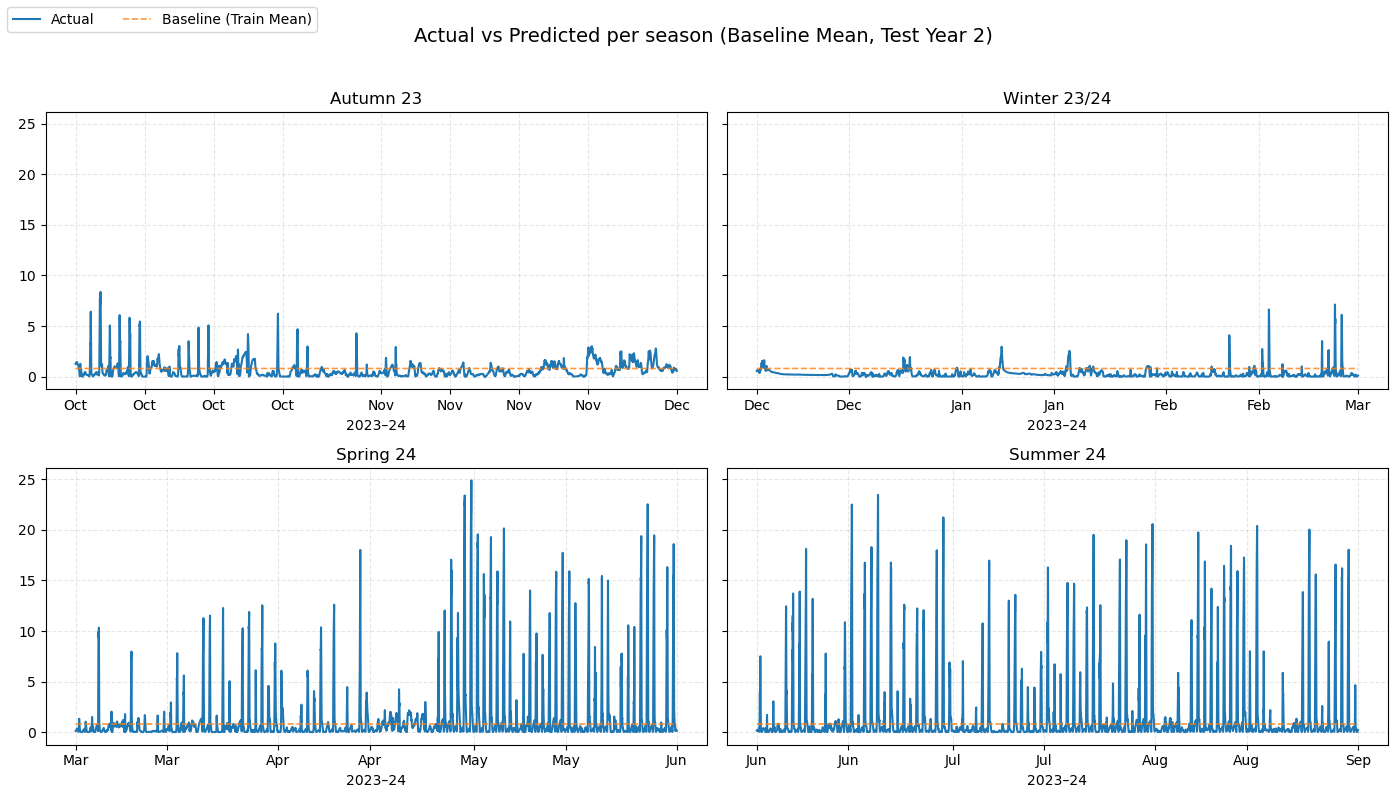

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.ravel()

for ax, (title, d1, d2) in zip(axes, season_blocks_en):
    block = YEAR2.loc[d1:d2]
    if block.empty:
        ax.set_visible(False)
        continue

    y_true = block[target]
    y_pred = np.full_like(y_true, fill_value=train_mean, dtype=np.float64)  # baseline gebruikt train-mean

    ax.plot(block.index, y_true, label="Actual", linewidth=1.5)
    ax.plot(block.index, y_pred, label="Baseline (Train Mean)", linestyle="--", linewidth=1.2, alpha=0.8)

    ax.set_title(title, fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xlabel("2023–24")
    ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2)

fig.suptitle("Actual vs Predicted per season (Baseline Mean, Test Year 2)", y=0.97, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import numpy as np, pandas as pd, math, warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")


# 1. Forecast targets 
horizons = {
    "30minutes":  (5, 6),
    "1hour":      (11, 12),
    "6hours":     (66, 72),
    "12hours":    (132, 144),
    "24hours":    (264, 288)
}

for label, (shift_n, roll_n) in horizons.items():
    df[f"Energy_sum_target_{label}"] = (
        df["Energy (J)"].shift(-shift_n).rolling(window=roll_n, min_periods=roll_n).sum()
    )

# Splitsen per jaar, daarna pas dropna
YEAR1 = df.loc["2022-10-01":"2023-09-30"].dropna()
YEAR2 = df.loc["2023-10-01":"2024-08-31"].dropna()


# 2. Seizoensblokken (jaar 2)
season_blocks = [
    ("Herfst 23",   "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Lente 24",    "2024-03-01", "2024-05-31"),
    ("Zomer 24",    "2024-06-01", "2024-08-31"),
]


# 3. Evaluatie loop over alle horizons
def metr(y_true, y_pred):
    return (
        mean_absolute_error(y_true, y_pred),
        math.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    )

results = {}

for label in horizons.keys():
    print(f"\n📉 Baseline mean model – Horizon: {label}")
    target = f"Energy_sum_target_{label}"

    # Train / Val split
    split_ix = int(len(YEAR1) * 0.8)
    train_df = YEAR1.iloc[:split_ix]
    val_df   = YEAR1.iloc[split_ix:]

    y_train = train_df[target]
    y_val   = val_df[target]

    train_mean = y_train.mean()

    # Train/val scores
    mae_tr, rmse_tr, r2_tr = metr(y_train, np.full_like(y_train, train_mean, dtype=np.float64))
    mae_v , rmse_v , r2_v  = metr(y_val,   np.full_like(y_val,   train_mean, dtype=np.float64))

    print(f"  TRAIN  MAE {mae_tr:.3f} | RMSE {rmse_tr:.3f} | R² {r2_tr:.3f}")
    print(f"  VAL    MAE {mae_v :.3f} | RMSE {rmse_v :.3f} | R² {r2_v :.3f}")

        season_mae, season_rmse, season_r2 = [], [], []
    print(f"  Seizoensscores (jaar 2)")

    for name, d1, d2 in season_blocks:
        block = YEAR2.loc[d1:d2]
        if block.empty:
            print(f"    {name:10s} – geen rijen")
            continue

        y_true = block[target]
        y_pred = np.full_like(y_true, train_mean, dtype=np.float64)

        mae, rmse, r2 = metr(y_true, y_pred)
        season_mae.append(mae)
        season_rmse.append(rmse)
        season_r2.append(r2)

        print(f"    {name:10s}  MAE {mae:.3f} | RMSE {rmse:.3f} | R² {r2:.3f}")

    results[label] = {
        "train_mae": mae_tr,
        "train_rmse": rmse_tr,
        "train_r2": r2_tr,

        "val_mae": mae_v,
        "val_rmse": rmse_v,
        "val_r2": r2_v,

        "test_mae": np.mean(season_mae),
        "test_rmse": np.mean(season_rmse),
        "test_r2": np.mean(season_r2),
    }


# 4. Samenvattende tabel
print("\n📊 Samenvatting per horizon (baseline):")

summary = pd.DataFrame([
    {
        "Horizon": k,
        "Train MAE": v["train_mae"],
        "Train RMSE": v["train_rmse"],
        "Train R²": v["train_r2"],

        "Val MAE": v["val_mae"],
        "Val RMSE": v["val_rmse"],
        "Val R²": v["val_r2"],

        "Test MAE": v["test_mae"],
        "Test RMSE": v["test_rmse"],
        "Test R²": v["test_r2"],
    }
    for k, v in results.items()
])

print(summary.round(3))



📉 Baseline mean model – Horizon: 30minutes
  TRAIN  MAE 0.460 | RMSE 1.063 | R² 0.000
  VAL    MAE 0.707 | RMSE 1.594 | R² -0.023
  Seizoensscores (jaar 2)
    Herfst 23   MAE 0.305 | RMSE 0.428 | R² -0.030
    Winter 23/24  MAE 0.311 | RMSE 0.357 | R² -1.184
    Lente 24    MAE 0.663 | RMSE 1.564 | R² -0.025
    Zomer 24    MAE 0.778 | RMSE 1.778 | R² -0.035

📉 Baseline mean model – Horizon: 1hour
  TRAIN  MAE 0.913 | RMSE 2.076 | R² 0.000
  VAL    MAE 1.404 | RMSE 3.110 | R² -0.024
  Seizoensscores (jaar 2)
    Herfst 23   MAE 0.602 | RMSE 0.831 | R² -0.032
    Winter 23/24  MAE 0.620 | RMSE 0.706 | R² -1.239
    Lente 24    MAE 1.316 | RMSE 3.056 | R² -0.027
    Zomer 24    MAE 1.545 | RMSE 3.473 | R² -0.037

📉 Baseline mean model – Horizon: 6hours
  TRAIN  MAE 4.976 | RMSE 9.232 | R² 0.000
  VAL    MAE 7.607 | RMSE 13.386 | R² -0.049
  Seizoensscores (jaar 2)
    Herfst 23   MAE 3.185 | RMSE 3.839 | R² -0.055
    Winter 23/24  MAE 3.603 | RMSE 3.865 | R² -1.987
    Lente 24    MAE